In [1]:
import sys
sys.path.append(r"E:\datalab\59")

In [2]:
# import libraries necessary for this project
import os, sys, pickle

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import seaborn as sns

from datetime import date

from sklearn.model_selection import KFold, train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, roc_auc_score, auc, roc_curve
from sklearn.preprocessing import MinMaxScaler

import xgboost as xgb
import lightgbm as lgb

# display for this notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
dfoff = pd.read_csv(r'E:\datalab\59\ccf_offline_stage1_train.csv')
dftest = pd.read_csv(r'E:\datalab\59\ccf_offline_stage1_test_revised.csv')

dfon = pd.read_csv(r'E:\datalab\59\ccf_online_stage1_train.csv')

dfoff.head(5)

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
0,1439408,2632,null,null,0,null,20160217
1,1439408,4663,11002,150:20,1,20160528,null
2,1439408,2632,8591,20:1,0,20160217,null
3,1439408,2632,1078,20:1,0,20160319,null
4,1439408,2632,8591,20:1,0,20160613,null


In [3]:
dfoff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1754884 entries, 0 to 1754883
Data columns (total 7 columns):
User_id          int64
Merchant_id      int64
Coupon_id        object
Discount_rate    object
Distance         object
Date_received    object
Date             object
dtypes: int64(2), object(5)
memory usage: 93.7+ MB


In [4]:
print('有优惠券，购买商品条数', dfoff[(dfoff['Date_received'] != 'null') & (dfoff['Date'] != 'null')].shape[0])
print('无优惠券，购买商品条数', dfoff[(dfoff['Date_received'] == 'null') & (dfoff['Date'] != 'null')].shape[0])
print('有优惠券，不购买商品条数', dfoff[(dfoff['Date_received'] != 'null') & (dfoff['Date'] == 'null')].shape[0])
print('无优惠券，不购买商品条数', dfoff[(dfoff['Date_received'] == 'null') & (dfoff['Date'] == 'null')].shape[0])

有优惠券，购买商品条数 75382
无优惠券，购买商品条数 701602
有优惠券，不购买商品条数 977900
无优惠券，不购买商品条数 0


In [5]:
# 在测试集中出现的用户但训练集没有出现
print('1. User_id in training set but not in test set', set(dftest['User_id']) - set(dfoff['User_id']))
# 在测试集中出现的商户但训练集没有出现
print('2. Merchant_id in training set but not in test set', set(dftest['Merchant_id']) - set(dfoff['Merchant_id']))

1. User_id in training set but not in test set {2495873, 1286474}
2. Merchant_id in training set but not in test set {5920}


Note:
数据中大量的购物券没有花掉(977900)，其中很多人购买商品没有优惠券(701602), 用优惠券购买商品的只有很少一部分人(75382)。
dftest中有2个用户是新的，没有出现在dfoff中。dftest中有1个商铺是新的，没有出现在dfoff中。

优惠券和距离

In [6]:
print('Discount_rate 类型:',dfoff['Discount_rate'].unique())
print('Distance 类型:', dfoff['Distance'].unique())

Discount_rate 类型: ['null' '150:20' '20:1' '200:20' '30:5' '50:10' '10:5' '100:10' '200:30'
 '20:5' '30:10' '50:5' '150:10' '100:30' '200:50' '100:50' '300:30'
 '50:20' '0.9' '10:1' '30:1' '0.95' '100:5' '5:1' '100:20' '0.8' '50:1'
 '200:10' '300:20' '100:1' '150:30' '300:50' '20:10' '0.85' '0.6' '150:50'
 '0.75' '0.5' '200:5' '0.7' '30:20' '300:10' '0.2' '50:30' '200:100'
 '150:5']
Distance 类型: ['0' '1' 'null' '2' '10' '4' '7' '9' '3' '5' '6' '8']


处理方式：将str变成 numeric

将满xx减yy类型(xx:yy)的券变成折扣率 : 1 - yy/xx，同时建立折扣券相关的特征 discount_rate, discount_man, discount_jian, discount_type
将距离 str 转为 int

In [17]:
# convert Discount_rate and Distance
def getDiscountType(row):
    if row == 'null':
        return 'null'
    elif ':' in row:
        return 1
    else:
        return 0

def convertRate(row):
    """Convert discount to rate"""
    if row == 'null':
        return 1.0
    elif ':' in row:
        rows = row.split(':')
        return 1.0 - float(rows[1])/float(rows[0])
    else:
        return float(row)
    
def getDiscountMan(row):
    if ':' in row:
        rows = row.split(':')
        return int(rows[0])
    else:
        return 0

def getDiscountJian(row):
    if ':' in row:
        rows = row.split(':')
        return int(rows[1])
    else:
        return 0
    
def processData(df):
    
# convert discount_rate
    df['discount_rate'] = df['Discount_rate'].apply(convertRate)
    df['discount_man'] = df['Discount_rate'].apply(getDiscountMan)
    df['discount_jian'] = df['Discount_rate'].apply(getDiscountJian)
    df['discount_type'] = df['Discount_rate'].apply(getDiscountType)
    print(df['discount_rate'].unique())
    
# convert distance
    df['distance'] = df['Distance'].replace('null', -1).astype(int)
    print(df['distance'].unique())
    return df

In [18]:
dfoff = processData(dfoff)
dftest = processData(dftest)

[1.         0.86666667 0.95       0.9        0.83333333 0.8
 0.5        0.85       0.75       0.66666667 0.93333333 0.7
 0.6        0.96666667 0.98       0.99       0.975      0.33333333
 0.2        0.4       ]
[ 0  1 -1  2 10  4  7  9  3  5  6  8]
[0.83333333 0.9        0.96666667 0.8        0.95       0.75
 0.98       0.5        0.86666667 0.6        0.66666667 0.7
 0.85       0.33333333 0.94       0.93333333 0.975      0.99      ]
[ 1 -1  5  2  0 10  3  6  7  4  9  8]


In [9]:
dfoff.head(2)

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,discount_rate,discount_man,discount_jian,discount_type,distance
0,1439408,2632,null,null,0,null,20160217,1.000000,0,0,null,0
1,1439408,4663,11002,150:20,1,20160528,null,0.866667,150,20,1,1


In [10]:
dftest.head(2)

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,discount_rate,discount_man,discount_jian,discount_type,distance
0,4129537,450,9983,30:5,1,20160712,0.833333,30,5,1,1
1,6949378,1300,3429,30:5,null,20160706,0.833333,30,5,1,-1


时间

这里有两个时间，Date_received和Date，即优惠券收到日期和消费日期。

In [20]:
date_received = dfoff['Date_received'].unique()
date_received = sorted(date_received[date_received != 'null'])

date_buy = dfoff['Date'].unique()
date_buy = sorted(date_buy[date_buy != 'null'])

date_buy = sorted(dfoff[dfoff['Date'] != 'null']['Date'])
print('优惠券收到日期从',date_received[0],'到', date_received[-1])
print('消费日期从', date_buy[0], '到', date_buy[-1])

优惠券收到日期从 20160101 到 20160615
消费日期从 20160101 到 20160630


看一下每天的顾客收到coupon的数目，以及收到coupon后用coupon消费的数目。

In [21]:
couponbydate=dfoff[dfoff['Date_received']!='null'][['Date_received','Date']].groupby(['Date_received'],as_index=False).count()
couponbydate.columns = ['Date_received','count']
buybydate = dfoff[(dfoff['Date'] != 'null') & (dfoff['Date_received'] != 'null')][['Date_received', 'Date']].groupby(['Date_received'], as_index=False).count()
buybydate.columns = ['Date_received','count']

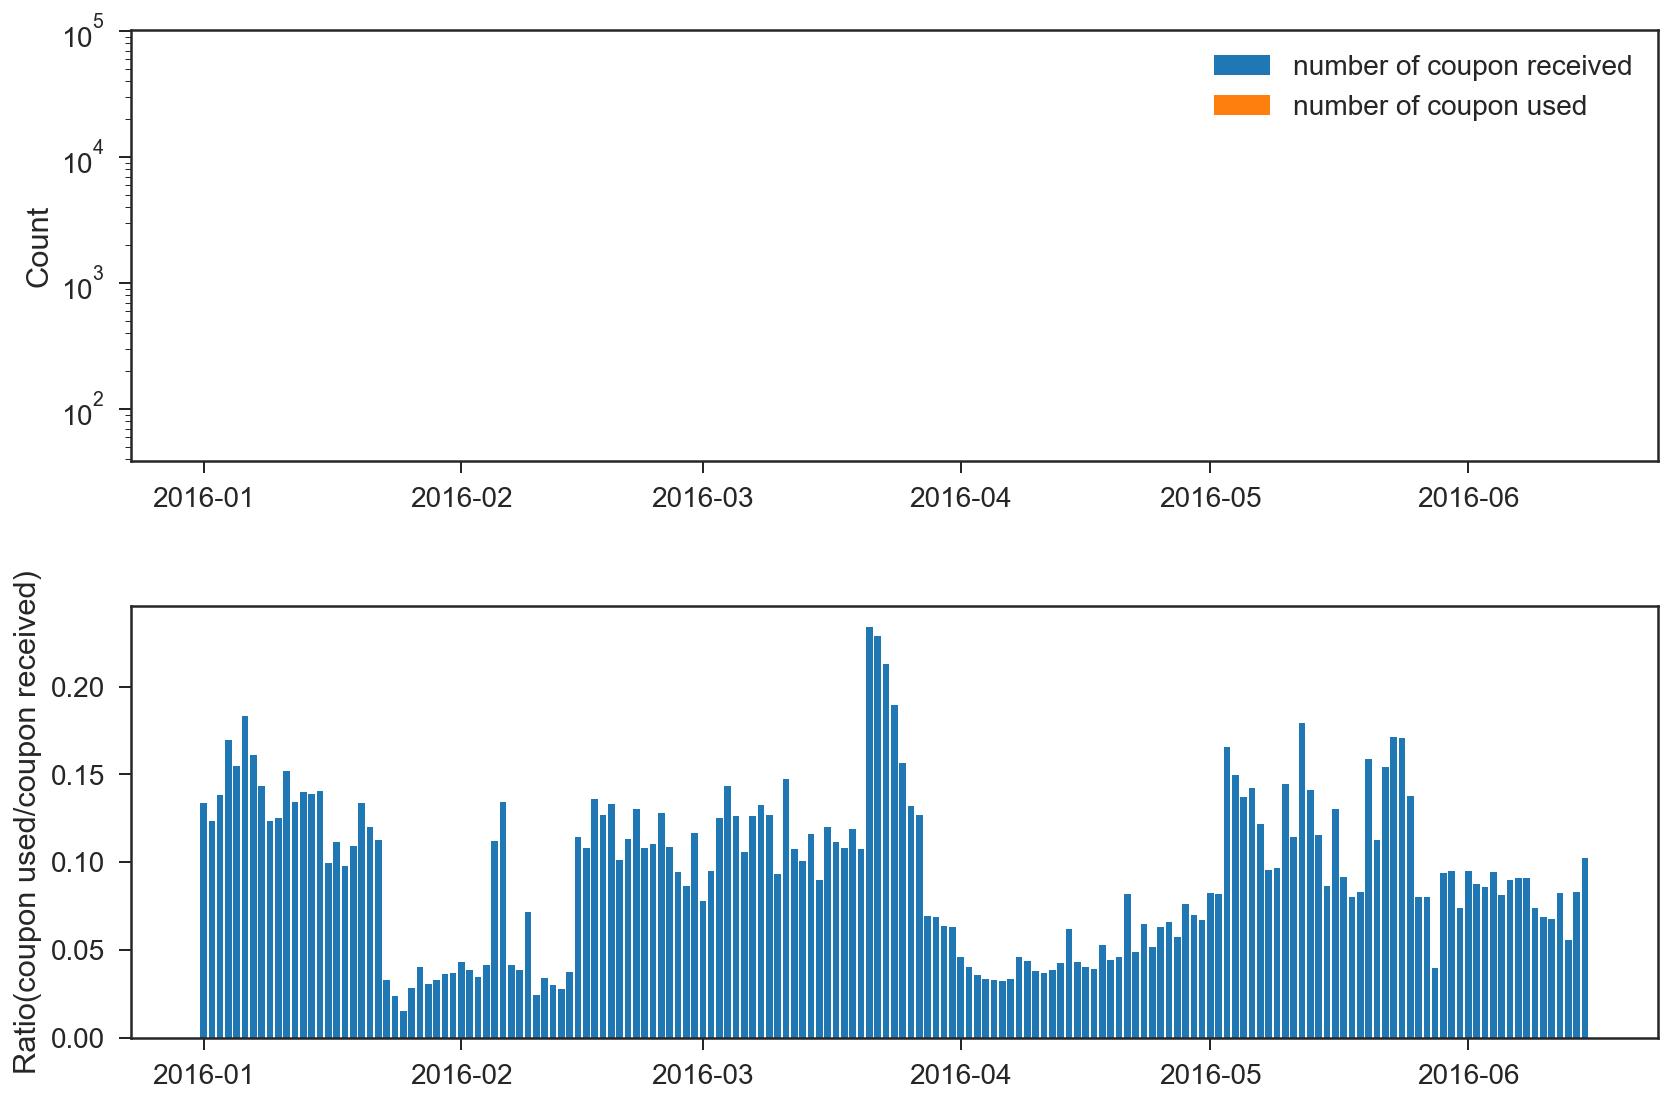

In [22]:
sns.set_style('ticks')
sns.set_context("notebook", font_scale= 1.4)
plt.figure(figsize = (12,8))
date_received_dt = pd.to_datetime(date_received, format='%Y%m%d')

plt.subplot(211)
plt.bar(date_received_dt, couponbydate['count'], label = 'number of coupon received' )
plt.bar(date_received_dt, buybydate['count'], label = 'number of coupon used')
plt.yscale('log')
plt.ylabel('Count')
plt.legend()

plt.subplot(212)
plt.bar(date_received_dt, buybydate['count']/couponbydate['count'])
plt.ylabel('Ratio(coupon used/coupon received)')
plt.tight_layout()

新建关于星期的特征

weekday: {1,2,3,4,5,6,7}
weekday_1, ..., weekday_7: {0,1}

In [23]:
def getWeekday(row):
    if row == 'null':
        return row
    else:
        return date(int(row[0:4]), int(row[4:6]), int(row[6:8])).weekday() + 1

dfoff['weekday'] = dfoff['Date_received'].astype(str).apply(getWeekday)
dftest['weekday'] = dftest['Date_received'].astype(str).apply(getWeekday)

# weekday_type :  周六和周日为1，其他为0
dfoff['weekday_type'] = dfoff['weekday'].apply(lambda x : 1 if x in [6,7] else 0 )
dftest['weekday_type'] = dftest['weekday'].apply(lambda x : 1 if x in [6,7] else 0 )

In [24]:
# change weekday to one-hot encoding 
weekdaycols = ['weekday_' + str(i) for i in range(1,8)]
print(weekdaycols)

tmpdf = pd.get_dummies(dfoff['weekday'].replace('null', np.nan))
tmpdf.columns = weekdaycols
dfoff[weekdaycols] = tmpdf

tmpdf = pd.get_dummies(dftest['weekday'].replace('null', np.nan))
tmpdf.columns = weekdaycols
dftest[weekdaycols] = tmpdf

['weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7']


数据标注

三类：

Date_received == 'null': y = -1
Date != 'null' & Date-Date_received <= 15: y = 1
Otherwise: y = 0

In [25]:
def label(row):
    if row['Date_received'] == 'null':
        return -1
    if row['Date'] != 'null':
        td = pd.to_datetime(row['Date'], format='%Y%m%d') -  pd.to_datetime(row['Date_received'], format='%Y%m%d')
        if td <= pd.Timedelta(15, 'D'):
            return 1
    return 0
dfoff['label'] = dfoff.apply(label, axis = 1)

In [26]:
print(dfoff['label'].value_counts())
#等价于dfoff['label'].groupby([dfoff['label']]).count()

 0    988887
-1    701602
 1     64395
Name: label, dtype: int64


In [27]:
print('已有columns：',dfoff.columns.tolist())

已有columns： ['User_id', 'Merchant_id', 'Coupon_id', 'Discount_rate', 'Distance', 'Date_received', 'Date', 'weekday', 'weekday_type', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7', 'label', 'discount_rate', 'discount_man', 'discount_jian', 'discount_type', 'distance']


In [28]:
dfoff.head(2)

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,weekday,weekday_type,weekday_1,...,weekday_4,weekday_5,weekday_6,weekday_7,label,discount_rate,discount_man,discount_jian,discount_type,distance
0,1439408,2632,null,null,0,null,20160217,null,0,0,...,0,0,0,0,-1,1.000000,0,0,null,0
1,1439408,4663,11002,150:20,1,20160528,null,6,1,0,...,0,0,1,0,0,0.866667,150,20,1,1


最Naïve的模型

直接用 discount, distance, weekday 类的特征。
train/valid 的划分：用20160101到20160515的作为train，20160516到20160615作为valid。
用线性模型 SGDClassifier

In [29]:
# data split
df = dfoff[dfoff['label'] != -1].copy()
train = df[(df['Date_received'] < '20160516')].copy()
valid = df[(df['Date_received'] >= '20160516') & (df['Date_received'] <= '20160615')].copy()
print(train['label'].value_counts())
print(valid['label'].value_counts())

0    759172
1     41524
Name: label, dtype: int64
0    229715
1     22871
Name: label, dtype: int64


In [30]:
# feature
original_feature = ['discount_rate','discount_type','discount_man', 'discount_jian','distance', 'weekday', 'weekday_type'] + weekdaycols
print(len(original_feature),original_feature)

14 ['discount_rate', 'discount_type', 'discount_man', 'discount_jian', 'distance', 'weekday', 'weekday_type', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7']


In [31]:
# model1
predictors = original_feature
print(predictors)

def check_model(data, predictors):
    
    classifier = lambda: SGDClassifier(
        loss='log', #损失函数选择项
        penalty='elasticnet', #惩罚方式
        fit_intercept=True, 
        max_iter=100, 
        shuffle=True, 
        n_jobs=1,#使计算并行运行
        class_weight=None)#加权类

    model = Pipeline(steps=[
        ('ss', StandardScaler()),
        ('en', classifier())
    ])

    parameters = {
        'en__alpha': [ 0.001, 0.01, 0.1],
        'en__l1_ratio': [ 0.001, 0.01, 0.1]
    }#对象名称，子对象名称，参数名称

    folder = StratifiedKFold(n_splits=3, shuffle=True)#分层的交叉验证
    
    grid_search = GridSearchCV(
        model, 
        parameters, 
        cv=folder, 
        n_jobs=-1, 
        verbose=1)
    grid_search = grid_search.fit(data[predictors], 
                                  data['label'])
    
    return grid_search

if not os.path.isfile('1_model.pkl'):
    model = check_model(train, predictors)
    print(model.best_score_)
    print(model.best_params_)
    with open('1_model.pkl', 'wb') as f:
        pickle.dump(model, f)
else:
    with open('1_model.pkl', 'rb') as f:
        model = pickle.load(f)

['discount_rate', 'discount_type', 'discount_man', 'discount_jian', 'distance', 'weekday', 'weekday_type', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7']


sklean提供的pipeline来将多个学习器组成流水线，通常流水线的形式为：
将数据标准化的学习器---特征提取的学习器---执行预测的学习器
除了最后一个学习器之外，前面的所有学习器必须提供transform方法，该方法用于数据转化（例如：归一化，正则化，以及特征提取

预测以及结果评价
这边对每个coupon预测的结果计算AUC，再对所有的coupon做平均。计算AUC的时候，如果label只有一类，就直接跳过，因为AUC无法计算。

In [32]:
# valid predict
y_valid_pred = model.predict_proba(valid[predictors])
valid1 = valid.copy()
valid1['pred_prob'] = y_valid_pred[:, 1]
valid1.head(2)

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,weekday,weekday_type,weekday_1,...,weekday_5,weekday_6,weekday_7,label,discount_rate,discount_man,discount_jian,discount_type,distance,pred_prob
1,1439408,4663,11002,150:20,1,20160528,null,6,1,0,...,0,1,0,0,0.866667,150,20,1,1,0.019543
4,1439408,2632,8591,20:1,0,20160613,null,1,0,1,...,0,0,0,0,0.950000,20,1,1,0,0.101493


In [33]:
y_valid_pred = model.predict_proba(valid[predictors])
y_valid_pred

array([[0.98045747, 0.01954253],
       [0.89850677, 0.10149323],
       [0.89850677, 0.10149323],
       ...,
       [0.96581474, 0.03418526],
       [0.98001784, 0.01998216],
       [0.88136205, 0.11863795]])

In [25]:
# avgAUC calculation
vg = valid1.groupby(['Coupon_id'])
aucs = []
for i in vg:
    tmpdf = i[1] 
    if len(tmpdf['label'].unique()) != 2:
        continue
    fpr, tpr, thresholds = roc_curve(tmpdf['label'], tmpdf['pred_prob'], pos_label=1)
    aucs.append(auc(fpr, tpr))
print(np.average(aucs))

0.5323444694516164


In [26]:
# test prediction for submission
y_test_pred = model.predict_proba(dftest[predictors])
dftest1 = dftest[['User_id','Coupon_id','Date_received']].copy()
dftest1['label'] = y_test_pred[:,1]
dftest1.to_csv('submit1.csv', index=False, header=False)
dftest1.head()

,User_id,Coupon_id,Date_received,label
0,4129537,9983,20160712,0.105254
1,6949378,3429,20160706,0.154109
2,2166529,6928,20160727,0.005530
3,2166529,1808,20160727,0.018760
4,6172162,6500,20160708,0.063495


这个提交结果线上在0.53左右，与valid的结果0.53很接近。这个结果比0.5高一点，但结果算很差。
整个过程中特征是优惠券，距离和时间，没有客户和商户的信息。下面将进行特征的提取。

特征提取

这边可以说是顾客和商户的profile建立，通过客户和商户以前的买卖情况，提取各自或者交叉的特征。选择哪个时间段的数据进行特征提取是可以探索的，
这里使用20160101到20160515之间的数据提取特征，20160516-20160615的数据作为训练集。

In [27]:
feature = dfoff[(dfoff['Date'] < '20160516') | ((dfoff['Date'] == 'null') & (dfoff['Date_received'] < '20160516'))].copy()
data = dfoff[(dfoff['Date_received'] >= '20160516') & (dfoff['Date_received'] <= '20160615')].copy()
print(data['label'].value_counts())

0    229715
1     22871
Name: label, dtype: int64


In [28]:
fdf = feature.copy()

用户 User 特征

In [59]:
# key of user
u = fdf[['User_id']].copy().drop_duplicates()

In [54]:
# u_coupon_count : num of coupon received by user
u1 = fdf[fdf['Date_received'] != 'null'][['User_id']].copy()
u1['u_coupon_count'] = 1
u1 = u1.groupby(['User_id'], as_index = False).count()
u1.head(2)

,User_id,u_coupon_count
0,4,1
1,35,4


In [38]:
# u_buy_count : times of user buy offline (with or without coupon)
u2 = fdf[fdf['Date'] != 'null'][['User_id']].copy()
u2['u_buy_count'] = 1
u2 = u2.groupby(['User_id'], as_index = False).count()
u2.head(2)

,User_id,u_buy_count
0,165,10
1,184,1


In [39]:
# u_buy_with_coupon : times of user buy offline (with coupon)
u3 = fdf[((fdf['Date'] != 'null') & (fdf['Date_received'] != 'null'))][['User_id']].copy()
u3['u_buy_with_coupon'] = 1
u3 = u3.groupby(['User_id'], as_index = False).count()
u3.head(2)

,User_id,u_buy_with_coupon
0,184,1
1,417,1


In [56]:
# u_merchant_count : num of merchant user bought from
u4 = fdf[fdf['Date'] != 'null'][['User_id', 'Merchant_id']].copy()
u4.drop_duplicates(inplace = True)#生成一个副本，删除重复项
u4 = u4.groupby(['User_id'], as_index = False).count()
u4.rename(columns = {'Merchant_id':'u_merchant_count'}, inplace = True)
u4.head(2)

,User_id,u_merchant_count
0,165,2
1,184,1


In [48]:
# u_min_distance
utmp = fdf[(fdf['Date'] != 'null') & (fdf['Date_received'] != 'null')][['User_id', 'distance']].copy()
utmp.replace(-1, np.nan, inplace = True)
u5 = utmp.groupby(['User_id'], as_index = False).min()
u5.rename(columns = {'distance':'u_min_distance'}, inplace = True)
u6 = utmp.groupby(['User_id'], as_index = False).max()
u6.rename(columns = {'distance':'u_max_distance'}, inplace = True)
u7 = utmp.groupby(['User_id'], as_index = False).mean()
u7.rename(columns = {'distance':'u_mean_distance'}, inplace = True)
u8 = utmp.groupby(['User_id'], as_index = False).median()
u8.rename(columns = {'distance':'u_median_distance'}, inplace = True)
u8.head(2)

,User_id,u_median_distance
0,184,0.0
1,417,0.0


In [57]:
u.shape, u1.shape, u2.shape, u3.shape, u4.shape, u5.shape, u6.shape, u7.shape, u8.shape

((453684,),
 (412635, 2),
 (173770, 2),
 (29594, 2),
 (173770, 2),
 (29594, 2),
 (29594, 2),
 (29594, 2),
 (29594, 2))

In [60]:
# merge all the features on key User_id
user_feature = pd.merge(u, u1, on = 'User_id', how = 'left')
user_feature = pd.merge(user_feature, u2, on = 'User_id', how = 'left')
user_feature = pd.merge(user_feature, u3, on = 'User_id', how = 'left')
user_feature = pd.merge(user_feature, u4, on = 'User_id', how = 'left')
user_feature = pd.merge(user_feature, u5, on = 'User_id', how = 'left')
user_feature = pd.merge(user_feature, u6, on = 'User_id', how = 'left')
user_feature = pd.merge(user_feature, u7, on = 'User_id', how = 'left')
user_feature = pd.merge(user_feature, u8, on = 'User_id', how = 'left')

In [63]:
# calculate rate

user_feature['u_use_coupon_rate'] = user_feature['u_buy_with_coupon'].astype('float')/user_feature['u_coupon_count'].astype('float')
user_feature['u_buy_with_coupon_rate'] = user_feature['u_buy_with_coupon'].astype('float')/user_feature['u_buy_count'].astype('float')
user_feature = user_feature.fillna(0)
user_feature.head(2)

,User_id,u_coupon_count,u_buy_count,u_buy_with_coupon,u_merchant_count,u_min_distance,u_max_distance,u_mean_distance,u_median_distance,u_use_coupon_rate,u_buy_with_coupon_rate
0,1439408,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1832624,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [71]:
# add user feature to data on key User_id
data2 = pd.merge(data, user_feature, on = 'User_id', how = 'left').fillna(0)

# split data2 into valid and train
# stratify是为了保持split前类的分布
# random_state,随机数种子,填0或不填，每次都会不一样。
train, valid = train_test_split(data2, test_size = 0.2, stratify = data2['label'], random_state=100)

In [76]:
# model2
predictors = original_feature + user_feature.columns.tolist()[1:]
print(len(predictors), predictors)

#如果path是一个存在的文件，返回True。否则返回False。
if not os.path.isfile('2_model.pkl'):
    model = check_model(train, predictors)
    print(model.best_score_)
    print(model.best_params_)
    with open('2_model.pkl', 'wb') as f:
        pickle.dump(model, f)
else:
    with open('2_model.pkl', 'rb') as f:
        model = pickle.load(f)

24 ['discount_rate', 'discount_type', 'discount_man', 'discount_jian', 'distance', 'weekday', 'weekday_type', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7', 'u_coupon_count', 'u_buy_count', 'u_buy_with_coupon', 'u_merchant_count', 'u_min_distance', 'u_max_distance', 'u_mean_distance', 'u_median_distance', 'u_use_coupon_rate', 'u_buy_with_coupon_rate']
Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  2.0min finished


0.9104410396500188
{'en__alpha': 0.001, 'en__l1_ratio': 0.001}


In [77]:
# valid set performance 
valid['pred_prob'] = model.predict_proba(valid[predictors])[:,1]
validgroup = valid.groupby(['Coupon_id'])
aucs = []
for i in validgroup:
    tmpdf = i[1] 
    if len(tmpdf['label'].unique()) != 2:
        continue
    fpr, tpr, thresholds = roc_curve(tmpdf['label'], tmpdf['pred_prob'], pos_label=1)
    
    aucs.append(auc(fpr, tpr))
    #aucs.append(roc_auc_score(tmpdf['label'], tmpdf['pred_prob']))
print(np.average(aucs))

D:\a\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


0.5975858233505388


商户 Merchant

In [89]:
# key of merchant
m = fdf[['Merchant_id']].copy().drop_duplicates()

In [79]:
# m_coupon_count : num of coupon from merchant
m1 = fdf[fdf['Date_received'] != 'null'][['Merchant_id']].copy()
m1['m_coupon_count'] = 1
m1 = m1.groupby(['Merchant_id'], as_index = False).count()
m1.head(2)

,Merchant_id,m_coupon_count
0,2,1
1,5,5


In [80]:
# m_sale_count : num of sale from merchant (with or without coupon)
m2 = fdf[fdf['Date'] != 'null'][['Merchant_id']].copy()
m2['m_sale_count'] = 1
m2 = m2.groupby(['Merchant_id'], as_index = False).count()
m2.head(2)

,Merchant_id,m_sale_count
0,1,5
1,3,8


In [81]:
# m_sale_with_coupon : num of sale from merchant with coupon usage
m3 = fdf[(fdf['Date'] != 'null') & (fdf['Date_received'] != 'null')][['Merchant_id']].copy()
m3['m_sale_with_coupon'] = 1
m3 = m3.groupby(['Merchant_id'], as_index = False).count()
m3.head(2)

,Merchant_id,m_sale_with_coupon
0,13,1
1,14,1


In [82]:
# m_min_distance
mtmp = fdf[(fdf['Date'] != 'null') & (fdf['Date_received'] != 'null')][['Merchant_id', 'distance']].copy()
mtmp.replace(-1, np.nan, inplace = True)
m4 = mtmp.groupby(['Merchant_id'], as_index = False).min()
m4.rename(columns = {'distance':'m_min_distance'}, inplace = True)
m5 = mtmp.groupby(['Merchant_id'], as_index = False).max()
m5.rename(columns = {'distance':'m_max_distance'}, inplace = True)
m6 = mtmp.groupby(['Merchant_id'], as_index = False).mean()
m6.rename(columns = {'distance':'m_mean_distance'}, inplace = True)
m7 = mtmp.groupby(['Merchant_id'], as_index = False).median()
m7.rename(columns = {'distance':'m_median_distance'}, inplace = True)
m7.head(2)

,Merchant_id,m_median_distance
0,13,0.0
1,14,0.0


In [83]:
m.shape, m1.shape, m2.shape, m3.shape, m4.shape, m5.shape, m6.shape, m7.shape

((7667, 1),
 (4196, 2),
 (7529, 2),
 (2253, 2),
 (2253, 2),
 (2253, 2),
 (2253, 2),
 (2253, 2))

In [90]:
merchant_feature = pd.merge(m, m1, on = 'Merchant_id', how = 'left')
merchant_feature = pd.merge(merchant_feature, m2, on = 'Merchant_id', how = 'left')
merchant_feature = pd.merge(merchant_feature, m3, on = 'Merchant_id', how = 'left')
merchant_feature = pd.merge(merchant_feature, m4, on = 'Merchant_id', how = 'left')
merchant_feature = pd.merge(merchant_feature, m5, on = 'Merchant_id', how = 'left')
merchant_feature = pd.merge(merchant_feature, m6, on = 'Merchant_id', how = 'left')
merchant_feature = pd.merge(merchant_feature, m7, on = 'Merchant_id', how = 'left')
merchant_feature = merchant_feature.fillna(0)
merchant_feature.head(5)

,Merchant_id,m_coupon_count,m_sale_count,m_sale_with_coupon,m_min_distance,m_max_distance,m_mean_distance,m_median_distance
0,2632,35.0,18.0,3.0,1.0,1.0,1.000000,1.0
1,3381,122834.0,18080.0,2487.0,0.0,10.0,1.652429,1.0
2,2099,16824.0,7227.0,1705.0,0.0,10.0,0.968072,0.0
3,1569,33492.0,896.0,135.0,0.0,10.0,2.260163,1.0
4,4833,8321.0,636.0,116.0,0.0,10.0,3.037736,2.0


In [91]:
merchant_feature['m_coupon_use_rate'] = merchant_feature['m_sale_with_coupon'].astype('float')/merchant_feature['m_coupon_count'].astype('float')
merchant_feature['m_sale_with_coupon_rate'] = merchant_feature['m_sale_with_coupon'].astype('float')/merchant_feature['m_sale_count'].astype('float')
merchant_feature = merchant_feature.fillna(0)
merchant_feature.head(2)

,Merchant_id,m_coupon_count,m_sale_count,m_sale_with_coupon,m_min_distance,m_max_distance,m_mean_distance,m_median_distance,m_coupon_use_rate,m_sale_with_coupon_rate
0,2632,35.0,18.0,3.0,1.0,1.0,1.000000,1.0,0.085714,0.166667
1,3381,122834.0,18080.0,2487.0,0.0,10.0,1.652429,1.0,0.020247,0.137555


In [92]:
# add merchant feature to data2
data3 = pd.merge(data2, merchant_feature, on = 'Merchant_id', how = 'left').fillna(0)

# split data3 into train/valid
train, valid = train_test_split(data3, test_size = 0.2, stratify = data3['label'], random_state=100)

In [93]:
# model 3
predictors = original_feature + user_feature.columns.tolist()[1:] + merchant_feature.columns.tolist()[1:]
print(predictors)

if not os.path.isfile('3_model.pkl'):
    model = check_model(train, predictors)
    print(model.best_score_)
    print(model.best_params_)
    with open('3_model.pkl', 'wb') as f:
        pickle.dump(model, f)
else:
    with open('3_model.pkl', 'rb') as f:
        model = pickle.load(f)

['discount_rate', 'discount_type', 'discount_man', 'discount_jian', 'distance', 'weekday', 'weekday_type', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7', 'u_coupon_count', 'u_buy_count', 'u_buy_with_coupon', 'u_merchant_count', 'u_min_distance', 'u_max_distance', 'u_mean_distance', 'u_median_distance', 'u_use_coupon_rate', 'u_buy_with_coupon_rate', 'm_coupon_count', 'm_sale_count', 'm_sale_with_coupon', 'm_min_distance', 'm_max_distance', 'm_mean_distance', 'm_median_distance', 'm_coupon_use_rate', 'm_sale_with_coupon_rate']
Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  1.6min finished


0.9110101549973276
{'en__alpha': 0.01, 'en__l1_ratio': 0.01}


In [105]:
valid['pred_prob'] = model.predict_proba(valid[predictors])[:,1]
validgroup = valid.groupby(['Coupon_id'])
aucs = []
for i in validgroup:
    tmpdf = i[1] 
    if len(tmpdf['label'].unique()) != 2:
        continue
    fpr, tpr, thresholds = roc_curve(tmpdf['label'], tmpdf['pred_prob'], pos_label=1)
    aucs.append(auc(fpr, tpr))
print(np.average(aucs))

D:\a\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


0.599153417557051


User & Merchant

In [111]:
# key of user and merchant
um = fdf[['User_id', 'Merchant_id']].copy().drop_duplicates()

In [113]:
um1 = fdf[['User_id', 'Merchant_id']].copy()
um1['um_count'] = 1
um1 = um1.groupby(['User_id', 'Merchant_id'], as_index = False).count()
um1.head(2)

,User_id,Merchant_id,um_count
0,4,1433,1
1,35,3381,4


In [114]:
um2 = fdf[fdf['Date'] != 'null'][['User_id', 'Merchant_id']].copy()
um2['um_buy_count'] = 1
um2 = um2.groupby(['User_id', 'Merchant_id'], as_index = False).count()
um2.head(2)

,User_id,Merchant_id,um_buy_count
0,165,2934,6
1,165,4195,4


In [115]:
um3 = fdf[fdf['Date_received'] != 'null'][['User_id', 'Merchant_id']].copy()
um3['um_coupon_count'] = 1
um3 = um3.groupby(['User_id', 'Merchant_id'], as_index = False).count()
um3.head(2)

,User_id,Merchant_id,um_coupon_count
0,4,1433,1
1,35,3381,4


In [116]:
um4 = fdf[(fdf['Date_received'] != 'null') & (fdf['Date'] != 'null')][['User_id', 'Merchant_id']].copy()
um4['um_buy_with_coupon'] = 1
um4 = um4.groupby(['User_id', 'Merchant_id'], as_index = False).count()
um4.head(2)

,User_id,Merchant_id,um_buy_with_coupon
0,184,3381,1
1,417,775,1


In [117]:
# merge all user merchant 
user_merchant_feature = pd.merge(um, um1, on = ['User_id','Merchant_id'], how = 'left')
user_merchant_feature = pd.merge(user_merchant_feature, um2, on = ['User_id','Merchant_id'], how = 'left')
user_merchant_feature = pd.merge(user_merchant_feature, um3, on = ['User_id','Merchant_id'], how = 'left')
user_merchant_feature = pd.merge(user_merchant_feature, um4, on = ['User_id','Merchant_id'], how = 'left')
user_merchant_feature = user_merchant_feature.fillna(0)

user_merchant_feature['um_buy_rate'] = user_merchant_feature['um_buy_count'].astype('float')/user_merchant_feature['um_count'].astype('float')
user_merchant_feature['um_coupon_use_rate'] = user_merchant_feature['um_buy_with_coupon'].astype('float')/user_merchant_feature['um_coupon_count'].astype('float')
user_merchant_feature['um_buy_with_coupon_rate'] = user_merchant_feature['um_buy_with_coupon'].astype('float')/user_merchant_feature['um_buy_count'].astype('float')
user_merchant_feature = user_merchant_feature.fillna(0)
user_merchant_feature.head(2)

,User_id,Merchant_id,um_count,um_buy_count,um_coupon_count,um_buy_with_coupon,um_buy_rate,um_coupon_use_rate,um_buy_with_coupon_rate
0,1439408,2632,3,1.0,2.0,0.0,0.333333,0.0,0.0
1,1832624,3381,1,0.0,1.0,0.0,0.000000,0.0,0.0


In [118]:
# add user_merchant_feature to data3
data4 = pd.merge(data3, user_merchant_feature, on = ['User_id','Merchant_id'], how = 'left').fillna(0)

# split data4 into train/valid
train, valid = train_test_split(data4, test_size = 0.2, stratify = data4['label'], random_state=100)

In [119]:
predictors = original_feature + user_feature.columns.tolist()[1:] + \
             merchant_feature.columns.tolist()[1:] + \
             user_merchant_feature.columns.tolist()[2:]
print(len(predictors),predictors)

if not os.path.isfile('4_model.pkl'):
    model = check_model(train, predictors)
    print(model.best_score_)
    print(model.best_params_)
    with open('4_model.pkl', 'wb') as f:
        pickle.dump(model, f)
else:
    with open('4_model.pkl', 'rb') as f:
        model = pickle.load(f)

40 ['discount_rate', 'discount_type', 'discount_man', 'discount_jian', 'distance', 'weekday', 'weekday_type', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7', 'u_coupon_count', 'u_buy_count', 'u_buy_with_coupon', 'u_merchant_count', 'u_min_distance', 'u_max_distance', 'u_mean_distance', 'u_median_distance', 'u_use_coupon_rate', 'u_buy_with_coupon_rate', 'm_coupon_count', 'm_sale_count', 'm_sale_with_coupon', 'm_min_distance', 'm_max_distance', 'm_mean_distance', 'm_median_distance', 'm_coupon_use_rate', 'm_sale_with_coupon_rate', 'um_count', 'um_buy_count', 'um_coupon_count', 'um_buy_with_coupon', 'um_buy_rate', 'um_coupon_use_rate', 'um_buy_with_coupon_rate']
Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  3.4min finished


0.9125789338242571
{'en__alpha': 0.01, 'en__l1_ratio': 0.001}


In [121]:
valid['pred_prob'] = model.predict_proba(valid[predictors])[:,1]
validgroup = valid.groupby(['Coupon_id'])
aucs = []
for i in validgroup:
    tmpdf = i[1] 
    if len(tmpdf['label'].unique()) != 2:
        continue
    fpr, tpr, thresholds = roc_curve(tmpdf['label'], tmpdf['pred_prob'], pos_label=1)
    aucs.append(auc(fpr, tpr))
print(np.average(aucs))

D:\a\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


0.6227748556978284


将上面特征处理写成function，可以方便后面重新划分数据

In [122]:
def userFeature(df):
    u = df[['User_id']].copy().drop_duplicates()
    
    # u_coupon_count : num of coupon received by user
    u1 = df[df['Date_received'] != 'null'][['User_id']].copy()
    u1['u_coupon_count'] = 1
    u1 = u1.groupby(['User_id'], as_index = False).count()

    # u_buy_count : times of user buy offline (with or without coupon)
    u2 = df[df['Date'] != 'null'][['User_id']].copy()
    u2['u_buy_count'] = 1
    u2 = u2.groupby(['User_id'], as_index = False).count()

    # u_buy_with_coupon : times of user buy offline (with coupon)
    u3 = df[((df['Date'] != 'null') & (df['Date_received'] != 'null'))][['User_id']].copy()
    u3['u_buy_with_coupon'] = 1
    u3 = u3.groupby(['User_id'], as_index = False).count()

    # u_merchant_count : num of merchant user bought from
    u4 = df[df['Date'] != 'null'][['User_id', 'Merchant_id']].copy()
    u4.drop_duplicates(inplace = True)
    u4 = u4.groupby(['User_id'], as_index = False).count()
    u4.rename(columns = {'Merchant_id':'u_merchant_count'}, inplace = True)

    # u_min_distance
    utmp = df[(df['Date'] != 'null') & (df['Date_received'] != 'null')][['User_id', 'distance']].copy()
    utmp.replace(-1, np.nan, inplace = True)
    u5 = utmp.groupby(['User_id'], as_index = False).min()
    u5.rename(columns = {'distance':'u_min_distance'}, inplace = True)
    u6 = utmp.groupby(['User_id'], as_index = False).max()
    u6.rename(columns = {'distance':'u_max_distance'}, inplace = True)
    u7 = utmp.groupby(['User_id'], as_index = False).mean()
    u7.rename(columns = {'distance':'u_mean_distance'}, inplace = True)
    u8 = utmp.groupby(['User_id'], as_index = False).median()
    u8.rename(columns = {'distance':'u_median_distance'}, inplace = True)

    user_feature = pd.merge(u, u1, on = 'User_id', how = 'left')
    user_feature = pd.merge(user_feature, u2, on = 'User_id', how = 'left')
    user_feature = pd.merge(user_feature, u3, on = 'User_id', how = 'left')
    user_feature = pd.merge(user_feature, u4, on = 'User_id', how = 'left')
    user_feature = pd.merge(user_feature, u5, on = 'User_id', how = 'left')
    user_feature = pd.merge(user_feature, u6, on = 'User_id', how = 'left')
    user_feature = pd.merge(user_feature, u7, on = 'User_id', how = 'left')
    user_feature = pd.merge(user_feature, u8, on = 'User_id', how = 'left')

    user_feature['u_use_coupon_rate'] = user_feature['u_buy_with_coupon'].astype('float')/user_feature['u_coupon_count'].astype('float')
    user_feature['u_buy_with_coupon_rate'] = user_feature['u_buy_with_coupon'].astype('float')/user_feature['u_buy_count'].astype('float')
    user_feature = user_feature.fillna(0)
    
    print(user_feature.columns.tolist())
    return user_feature

In [123]:
def merchantFeature(df):
    m = df[['Merchant_id']].copy().drop_duplicates()

    # m_coupon_count : num of coupon from merchant
    m1 = df[df['Date_received'] != 'null'][['Merchant_id']].copy()
    m1['m_coupon_count'] = 1
    m1 = m1.groupby(['Merchant_id'], as_index = False).count()

    # m_sale_count : num of sale from merchant (with or without coupon)
    m2 = df[df['Date'] != 'null'][['Merchant_id']].copy()
    m2['m_sale_count'] = 1
    m2 = m2.groupby(['Merchant_id'], as_index = False).count()

    # m_sale_with_coupon : num of sale from merchant with coupon usage
    m3 = df[(df['Date'] != 'null') & (df['Date_received'] != 'null')][['Merchant_id']].copy()
    m3['m_sale_with_coupon'] = 1
    m3 = m3.groupby(['Merchant_id'], as_index = False).count()

    # m_min_distance
    mtmp = df[(df['Date'] != 'null') & (df['Date_received'] != 'null')][['Merchant_id', 'distance']].copy()
    mtmp.replace(-1, np.nan, inplace = True)
    m4 = mtmp.groupby(['Merchant_id'], as_index = False).min()
    m4.rename(columns = {'distance':'m_min_distance'}, inplace = True)
    m5 = mtmp.groupby(['Merchant_id'], as_index = False).max()
    m5.rename(columns = {'distance':'m_max_distance'}, inplace = True)
    m6 = mtmp.groupby(['Merchant_id'], as_index = False).mean()
    m6.rename(columns = {'distance':'m_mean_distance'}, inplace = True)
    m7 = mtmp.groupby(['Merchant_id'], as_index = False).median()
    m7.rename(columns = {'distance':'m_median_distance'}, inplace = True)
    
    merchant_feature = pd.merge(m, m1, on = 'Merchant_id', how = 'left')
    merchant_feature = pd.merge(merchant_feature, m2, on = 'Merchant_id', how = 'left')
    merchant_feature = pd.merge(merchant_feature, m3, on = 'Merchant_id', how = 'left')
    merchant_feature = pd.merge(merchant_feature, m4, on = 'Merchant_id', how = 'left')
    merchant_feature = pd.merge(merchant_feature, m5, on = 'Merchant_id', how = 'left')
    merchant_feature = pd.merge(merchant_feature, m6, on = 'Merchant_id', how = 'left')
    merchant_feature = pd.merge(merchant_feature, m7, on = 'Merchant_id', how = 'left')

    merchant_feature['m_coupon_use_rate'] = merchant_feature['m_sale_with_coupon'].astype('float')/merchant_feature['m_coupon_count'].astype('float')
    merchant_feature['m_sale_with_coupon_rate'] = merchant_feature['m_sale_with_coupon'].astype('float')/merchant_feature['m_sale_count'].astype('float')
    merchant_feature = merchant_feature.fillna(0)
    
    print(merchant_feature.columns.tolist())
    return merchant_feature

In [124]:
def usermerchantFeature(df):

    um = df[['User_id', 'Merchant_id']].copy().drop_duplicates()

    um1 = df[['User_id', 'Merchant_id']].copy()
    um1['um_count'] = 1
    um1 = um1.groupby(['User_id', 'Merchant_id'], as_index = False).count()

    um2 = df[df['Date'] != 'null'][['User_id', 'Merchant_id']].copy()
    um2['um_buy_count'] = 1
    um2 = um2.groupby(['User_id', 'Merchant_id'], as_index = False).count()

    um3 = df[df['Date_received'] != 'null'][['User_id', 'Merchant_id']].copy()
    um3['um_coupon_count'] = 1
    um3 = um3.groupby(['User_id', 'Merchant_id'], as_index = False).count()

    um4 = df[(df['Date_received'] != 'null') & (df['Date'] != 'null')][['User_id', 'Merchant_id']].copy()
    um4['um_buy_with_coupon'] = 1
    um4 = um4.groupby(['User_id', 'Merchant_id'], as_index = False).count()

    user_merchant_feature = pd.merge(um, um1, on = ['User_id','Merchant_id'], how = 'left')
    user_merchant_feature = pd.merge(user_merchant_feature, um2, on = ['User_id','Merchant_id'], how = 'left')
    user_merchant_feature = pd.merge(user_merchant_feature, um3, on = ['User_id','Merchant_id'], how = 'left')
    user_merchant_feature = pd.merge(user_merchant_feature, um4, on = ['User_id','Merchant_id'], how = 'left')
    user_merchant_feature = user_merchant_feature.fillna(0)

    user_merchant_feature['um_buy_rate'] = user_merchant_feature['um_buy_count'].astype('float')/user_merchant_feature['um_count'].astype('float')
    user_merchant_feature['um_coupon_use_rate'] = user_merchant_feature['um_buy_with_coupon'].astype('float')/user_merchant_feature['um_coupon_count'].astype('float')
    user_merchant_feature['um_buy_with_coupon_rate'] = user_merchant_feature['um_buy_with_coupon'].astype('float')/user_merchant_feature['um_buy_count'].astype('float')
    
    user_merchant_feature = user_merchant_feature.fillna(0)

    print(user_merchant_feature.columns.tolist())
    return user_merchant_feature

In [125]:
def featureProcess(feature, train, test):
    """
    feature engineering from feature data
    then assign user, merchant, and user_merchant feature for train and test 
    """
    
    user_feature = userFeature(feature)
    merchant_feature = merchantFeature(feature)
    user_merchant_feature = usermerchantFeature(feature)
    
    train = pd.merge(train, user_feature, on = 'User_id', how = 'left')
    train = pd.merge(train, merchant_feature, on = 'Merchant_id', how = 'left')
    train = pd.merge(train, user_merchant_feature, on = ['User_id', 'Merchant_id'], how = 'left')
    train = train.fillna(0)
    
    test = pd.merge(test, user_feature, on = 'User_id', how = 'left')
    test = pd.merge(test, merchant_feature, on = 'Merchant_id', how = 'left')
    test = pd.merge(test, user_merchant_feature, on = ['User_id', 'Merchant_id'], how = 'left')
    test = test.fillna(0)
    
    return train, test

重复上面结果

In [126]:
# repeat result above and process dftest data
feature = dfoff[(dfoff['Date'] < '20160516') | ((dfoff['Date'] == 'null') & (dfoff['Date_received'] < '20160516'))].copy()
data = dfoff[(dfoff['Date_received'] >= '20160516') & (dfoff['Date_received'] <= '20160615')].copy()
print(data['label'].value_counts())

# feature engineering
train, test = featureProcess(feature, data, dftest)

0    229715
1     22871
Name: label, dtype: int64
['User_id', 'u_coupon_count', 'u_buy_count', 'u_buy_with_coupon', 'u_merchant_count', 'u_min_distance', 'u_max_distance', 'u_mean_distance', 'u_median_distance', 'u_use_coupon_rate', 'u_buy_with_coupon_rate']
['Merchant_id', 'm_coupon_count', 'm_sale_count', 'm_sale_with_coupon', 'm_min_distance', 'm_max_distance', 'm_mean_distance', 'm_median_distance', 'm_coupon_use_rate', 'm_sale_with_coupon_rate']
['User_id', 'Merchant_id', 'um_count', 'um_buy_count', 'um_coupon_count', 'um_buy_with_coupon', 'um_buy_rate', 'um_coupon_use_rate', 'um_buy_with_coupon_rate']


In [128]:
# features
predictors = ['discount_rate', 'discount_man', 'discount_jian', 'discount_type', 'distance',
              'weekday', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 
              'weekday_7', 'weekday_type', 
              'u_coupon_count', 'u_buy_count', 'u_buy_with_coupon', 'u_merchant_count', 'u_min_distance', 
              'u_max_distance', 'u_mean_distance', 'u_median_distance', 'u_use_coupon_rate', 'u_buy_with_coupon_rate', 
              'm_coupon_count', 'm_sale_count', 'm_sale_with_coupon', 'm_min_distance', 'm_max_distance',
              'm_mean_distance', 'm_median_distance', 'm_coupon_use_rate', 'm_sale_with_coupon_rate', 'um_count', 'um_buy_count', 
              'um_coupon_count', 'um_buy_with_coupon', 'um_buy_rate', 'um_coupon_use_rate', 'um_buy_with_coupon_rate']
print(len(predictors), predictors)

40 ['discount_rate', 'discount_man', 'discount_jian', 'discount_type', 'distance', 'weekday', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7', 'weekday_type', 'u_coupon_count', 'u_buy_count', 'u_buy_with_coupon', 'u_merchant_count', 'u_min_distance', 'u_max_distance', 'u_mean_distance', 'u_median_distance', 'u_use_coupon_rate', 'u_buy_with_coupon_rate', 'm_coupon_count', 'm_sale_count', 'm_sale_with_coupon', 'm_min_distance', 'm_max_distance', 'm_mean_distance', 'm_median_distance', 'm_coupon_use_rate', 'm_sale_with_coupon_rate', 'um_count', 'um_buy_count', 'um_coupon_count', 'um_buy_with_coupon', 'um_buy_rate', 'um_coupon_use_rate', 'um_buy_with_coupon_rate']


In [129]:
trainSub, validSub = train_test_split(train, test_size = 0.2, stratify = train['label'], random_state=100)

In [130]:
# linear model
model = check_model(trainSub, predictors)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  2.1min finished


In [131]:
validSub['pred_prob'] = model.predict_proba(validSub[predictors])[:,1]
validgroup = validSub.groupby(['Coupon_id'])
aucs = []
for i in validgroup:
    tmpdf = i[1] 
    if len(tmpdf['label'].unique()) != 2:
        continue
    fpr, tpr, thresholds = roc_curve(tmpdf['label'], tmpdf['pred_prob'], pos_label=1)
    aucs.append(auc(fpr, tpr))
print(np.average(aucs))

D:\a\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


0.6232752889067914


In [132]:
model = lgb.LGBMClassifier(
                    learning_rate = 0.01,
                    boosting_type = 'gbdt',
                    objective = 'binary',
                    metric = 'logloss',
                    max_depth = 5,
                    sub_feature = 0.7,
                    num_leaves = 3,
                    colsample_bytree = 0.7,
                    n_estimators = 5000,
                    early_stop = 50,
                    verbose = -1)
model.fit(trainSub[predictors], trainSub['label'])

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.7,
        early_stop=50, importance_type='split', learning_rate=0.01,
        max_depth=5, metric='logloss', min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=5000,
        n_jobs=-1, num_leaves=3, objective='binary', random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, sub_feature=0.7,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
        verbose=-1)

In [133]:
validSub['pred_prob'] = model.predict_proba(validSub[predictors])[:,1]
validgroup = validSub.groupby(['Coupon_id'])
aucs = []
for i in validgroup:
    tmpdf = i[1] 
    if len(tmpdf['label'].unique()) != 2:
        continue
    fpr, tpr, thresholds = roc_curve(tmpdf['label'], tmpdf['pred_prob'], pos_label=1)
    aucs.append(auc(fpr, tpr))
print(np.average(aucs))

D:\a\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


0.6315035180062087


In [134]:
# test prediction for submission
y_test_pred = model.predict_proba(test[predictors])
submit = test[['User_id','Coupon_id','Date_received']].copy()
submit['label'] = y_test_pred[:,1]
submit.to_csv('submit2.csv', index=False, header=False)
submit.head()

,User_id,Coupon_id,Date_received,label
0,4129537,9983,20160712,0.013701
1,6949378,3429,20160706,0.147059
2,2166529,6928,20160727,0.006868
3,2166529,1808,20160727,0.006674
4,6172162,6500,20160708,0.081664
